In [72]:
from codes.data_utils import set_seed

import codes.Spain.data_utils_spain
import codes.Spain.preprocess_covid_spain
import importlib
import codes.data_utils

importlib.reload(codes.Spain.data_utils_spain)
importlib.reload(codes.Spain.preprocess_covid_spain)
importlib.reload(codes.data_utils)

from codes.Spain.data_utils_spain import *
from codes.Spain.preprocess_covid_spain import *
from codes.data_utils import *

In [73]:
set_seed(42)
centrality_df = pd.read_csv("data/Spain/centrality_provinces.csv")
print(centrality_df.head())

   Codmundv           nomemun
0         0          A Coruña
1         1          Albacete
2         2  Alicante/Alacant
3         3           Almería
4         4       Araba/Álava


In [74]:
mobility_df = clean_spanish_mobility_data(
    file_path="data/Spain/Spanish-Mobility-Raw.xlsx",
    centrality_path="data/Spain/centrality_provinces.csv",
    save_path="data/Spain/mobility_cleaned_final.csv"
)

cities = sorted(set(mobility_df['origin']).union(set(mobility_df['destination'])))
cities_index = {cid: i for i, cid in enumerate(cities)}
N = len(cities)
print(f"Number of Cities: {N}")

avg_matrix = pd.DataFrame(0.0, index=cities, columns=cities)
for _, row in mobility_df.iterrows():
    i, j, w = row['origin'], row['destination'], row['weight']
    avg_matrix.at[i, j] = w
    
print("Shape of avg_matrix:", avg_matrix.shape)

[✓] Final cleaned mobility data saved to: data/Spain/mobility_cleaned_final.csv
Number of Cities: 52
Shape of avg_matrix: (52, 52)


In [75]:
cities = sorted(centrality_df['nomemun'].unique())
avg_matrix = pd.DataFrame(0.0, index=cities, columns=cities)
for _, row in mobility_df.iterrows():
    i, j, w = row['PROVINCIA ORIGEN'], row['PROVINCIA DESTINO'], row['weight']
    avg_matrix.at[i, j] = w

pop_df = pd.read_csv("data/Spain/final_cleaned_population_by_province_2025.csv")
scaler = MinMaxScaler()
pop_df["Population_2025_Normalized"] = scaler.fit_transform(pop_df[["Population_2025"]])

pop_dict = dict(zip(pop_df["Province"], pop_df["Population_2025_Normalized"]))
node_pop_features = [pop_dict.get(city.title().strip(), 0.0) for city in cities]

backbone_df = extract_backbone_from_avg_matrix(avg_matrix, cities, alpha=0.01, top_k=5)
pyg_data = build_pyg_graph_from_backbone(centrality_df, backbone_df)

pyg_data.x = torch.tensor(node_pop_features).unsqueeze(1)

print(f"Backbone extracted with {len(backbone_df)} edges")
print(backbone_df.shape)
print(pyg_data)

[✓] Extracting backbone using pij < 0.01 and top-5 neighbors
[✓] Filtered down to 275 edges from 2478
[✓] Graph built with 52 nodes and 180 edges.
[✓] Converted to PyTorch Geometric format.
Backbone extracted with 275 edges
(275, 7)
Data(edge_index=[2, 360], weight=[360], edge_attr=[360, 1], num_nodes=52, x=[52, 1])


In [76]:
# Normalize edges so (A, B) and (B, A) are treated the same
normalized_edges = backbone_df.apply(
    lambda row: tuple(sorted([row['source'], row['target']])), axis=1
)

num_unique_edges = len(set(normalized_edges))
print(f"Unique undirected edges: {num_unique_edges}")

Unique undirected edges: 180


In [77]:
df_covid = pd.read_csv("data/Spain/provincias_covid19_datos_sanidad_nueva_serie.csv")
filtered_covid_df = filter_and_scale_spanish_covid_by_centrality(df_covid)

city_case_counts = filtered_covid_df['cod_ine'].value_counts().sort_index()
print(filtered_covid_df.head(100000))

[✓] Filtered to 52 provinces, 40,872 rows.
[✓] Applied Z-score normalization on daily cases (Casos).
[✓] Saved filtered + scaled Spanish COVID data to 'data/Spain/filtered_scaled_covid.csv'.
            Fecha  cod_ine         provincia  Casos  Fallecidos  \
0      2020-01-01        0         No consta      0           0   
1      2020-01-01        1       Araba/Álava      0           0   
2      2020-01-01        2          Albacete      0           0   
3      2020-01-01        3  Alicante/Alacant      0           0   
4      2020-01-01        4           Almería      0           0   
...           ...      ...               ...    ...         ...   
41652  2022-02-24       47        Valladolid      0           0   
41653  2022-02-24       48           Bizkaia     15           0   
41654  2022-02-24       49            Zamora      0           0   
41655  2022-02-24       50          Zaragoza      0           0   
41656  2022-02-24       51             Ceuta      0           0   

    

In [78]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("cpu")
    print('Using cpu')
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Using cpu


In [79]:
# Rename columns for compatibility
spain_covid_df = (
    filtered_covid_df
    .rename(columns={"cod_ine": "ibgeID", "Fecha": "date"})  # 🔁 Rename to match expected schema
)

# spain_covid_df = spain_covid_df[spain_covid_df['provincia'] == 'Barcelona']

X_train_slide, X_test_slide, Y_train_slide, Y_test_slide = generate_sliding_temporal_graph_data(
    spain_covid_df,
    input_window=14,
    output_window=1,
    feature_column="z_newCases",
    device=device,
    train_split=0.8
)

print(X_train_slide.shape)

[✓] Sliding window: X torch.Size([772, 14, 52, 1]), Y torch.Size([772, 1, 52, 1])
[✓] Train: torch.Size([617, 14, 52, 1]), Test: torch.Size([155, 14, 52, 1])
torch.Size([617, 14, 52, 1])


In [80]:
import codes.models.custom_gcn_transformer_parallel
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

importlib.reload(codes.models.custom_gcn_transformer_parallel)

from codes.models.custom_gcn_transformer_parallel import SpatioTemporalFusionNet

N = pyg_data.num_nodes

model = SpatioTemporalFusionNet(
    in_channels=1,           # number of time-series features per node (e.g., newCases)
    graph_feat_dim=1,        # number of static node features (e.g., population, centrality, etc.)
    trans_hidden=64,         # hidden dim for transformer and GCN
    out_channels=1,          # output features per node (e.g., predicting next-day cases)
    num_nodes=N              # number of nodes in the graph used for graph embeddings
).to(device)

model.static_node_features = pyg_data.x.to(device)
# Loss function
criterion = nn.MSELoss() 
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.75)  # reduce LR by half every 5 epochs

In [81]:
from torch.utils.data import Dataset, DataLoader

class CovidGraphDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [82]:
batch_size = 32  # You can tune this based on your GPU

train_dataset = CovidGraphDataset(X_train_slide, Y_train_slide)
test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [83]:
edge_index = pyg_data.edge_index.to(device)
edge_weight = pyg_data.edge_attr.view(-1).to(device)

In [85]:
num_epochs = 20
batch_size_nodes = 500  # Adjust based on GPU capability
num_nodes = N  # 5383 nodes total

In [86]:
from torch_geometric.utils import subgraph
from tqdm import tqdm
import time

train_loss_hist, val_loss_hist, epoch_times = [], [], []

model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"🧠 Epoch {epoch+1}/{num_epochs}")
    start_time = time.time()

    for batch_X, batch_Y in pbar:
        batch_X = batch_X.to(device)  # [B, T, N, F]
        batch_Y = batch_Y.to(device)  # [B, N, 1]
        batch_Y = batch_Y.squeeze(1)

        node_losses = 0.0
        num_node_batches = 0

        for node_start in range(0, num_nodes, batch_size_nodes):
            node_end = min(node_start + batch_size_nodes, num_nodes)
            node_indices = torch.arange(node_start, node_end, device=device)

            # Subset node data
            batch_X_nodes = batch_X[:, :, node_start:node_end, :]
            batch_Y_nodes = batch_Y[:, node_start:node_end, :]

            # Subset edge_index
            edge_index_sub, edge_weight_sub = subgraph(
                node_indices, edge_index, edge_weight,
                relabel_nodes=True, num_nodes=num_nodes
            )

            # **Zero gradients per node-batch**
            optimizer.zero_grad()

            # Forward and backward pass
            output = model(batch_X_nodes, edge_index_sub, edge_weight_sub, node_indices=node_indices)
            batch_loss = criterion(output, batch_Y_nodes)
            batch_loss.backward()

            # **Optimizer step per node-batch**
            optimizer.step()

            # Track loss
            node_losses += batch_loss.item()
            num_node_batches += 1

        # Average loss over node-batches for current global batch
        avg_node_loss = node_losses / num_node_batches
        total_loss += avg_node_loss

        pbar.set_postfix({"Loss": f"{avg_node_loss:.4f}"})

    avg_epoch_loss = total_loss / len(train_loader)
    train_loss_hist.append(avg_epoch_loss)
    
    model.eval()
    with torch.no_grad():
        val_total, val_batches = 0.0, 0
        for vx, vy in test_loader:
            vx, vy = vx.to(device), vy.to(device).squeeze(1)
            node_losses, chunks = 0.0, 0
            for s in range(0, num_nodes, batch_size_nodes):
                e = min(s + batch_size_nodes, num_nodes)
                idx = torch.arange(s, e, device=device)
                vx_n = vx[:, :, s:e, :]
                vy_n = vy[:, s:e, :]
                ei_sub, ew_sub = subgraph(idx, edge_index, edge_weight, relabel_nodes=True, num_nodes=num_nodes)
                out = model(vx_n, ei_sub, ew_sub, node_indices=idx)
                node_losses += criterion(out, vy_n).item()
                chunks += 1
            val_total += node_losses / chunks
            val_batches += 1
    model.train()
    val_loss_hist.append(val_total / val_batches)
    
    elapsed = time.time() - start_time
    epoch_times.append(elapsed)

    print(f"✅ Epoch {epoch+1}/{num_epochs} — Avg Loss: {avg_epoch_loss:.4f} | "
          f"Val Loss: {val_loss_hist[-1]:.4f} | Time: {elapsed:.2f}s")
    scheduler.step()
    
print(f"Average Epoch time: {np.mean(epoch_times):.2f}s")

🧠 Epoch 1/20: 100%|██████████| 20/20 [00:08<00:00,  2.39it/s, Loss=0.0277]


✅ Epoch 1/20 — Avg Loss: 0.0764 | Val Loss: 2.0125 | Time: 8.67s


🧠 Epoch 2/20: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s, Loss=0.0673]


✅ Epoch 2/20 — Avg Loss: 0.0576 | Val Loss: 1.9394 | Time: 8.29s


🧠 Epoch 3/20: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, Loss=0.0340]


✅ Epoch 3/20 — Avg Loss: 0.0524 | Val Loss: 1.6234 | Time: 8.28s


🧠 Epoch 4/20: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, Loss=0.0411]


✅ Epoch 4/20 — Avg Loss: 0.0423 | Val Loss: 1.4081 | Time: 8.27s


🧠 Epoch 5/20: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s, Loss=0.0363]


✅ Epoch 5/20 — Avg Loss: 0.0326 | Val Loss: 1.3855 | Time: 8.35s


🧠 Epoch 6/20: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, Loss=0.0137]


✅ Epoch 6/20 — Avg Loss: 0.0287 | Val Loss: 1.4023 | Time: 8.22s


🧠 Epoch 7/20: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s, Loss=0.0276]


✅ Epoch 7/20 — Avg Loss: 0.0274 | Val Loss: 1.0846 | Time: 8.31s


🧠 Epoch 8/20: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, Loss=0.0114]


✅ Epoch 8/20 — Avg Loss: 0.0231 | Val Loss: 0.9420 | Time: 8.29s


🧠 Epoch 9/20: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s, Loss=0.0126]


✅ Epoch 9/20 — Avg Loss: 0.0227 | Val Loss: 0.9374 | Time: 8.16s


🧠 Epoch 10/20: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s, Loss=0.0492]


✅ Epoch 10/20 — Avg Loss: 0.0233 | Val Loss: 0.8378 | Time: 8.34s


🧠 Epoch 11/20: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, Loss=0.0267]


✅ Epoch 11/20 — Avg Loss: 0.0238 | Val Loss: 0.8904 | Time: 8.25s


🧠 Epoch 12/20: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, Loss=0.0111]


✅ Epoch 12/20 — Avg Loss: 0.0205 | Val Loss: 0.8797 | Time: 8.24s


🧠 Epoch 13/20: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, Loss=0.0158]


✅ Epoch 13/20 — Avg Loss: 0.0201 | Val Loss: 0.9374 | Time: 8.23s


🧠 Epoch 14/20: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, Loss=0.0175]


✅ Epoch 14/20 — Avg Loss: 0.0204 | Val Loss: 0.7741 | Time: 8.29s


🧠 Epoch 15/20: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, Loss=0.0220]


✅ Epoch 15/20 — Avg Loss: 0.0206 | Val Loss: 0.9388 | Time: 8.23s


🧠 Epoch 16/20: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s, Loss=0.0182]


✅ Epoch 16/20 — Avg Loss: 0.0202 | Val Loss: 0.7680 | Time: 8.25s


🧠 Epoch 17/20: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s, Loss=0.0238]


✅ Epoch 17/20 — Avg Loss: 0.0203 | Val Loss: 0.7953 | Time: 8.23s


🧠 Epoch 18/20: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s, Loss=0.0216]


✅ Epoch 18/20 — Avg Loss: 0.0216 | Val Loss: 0.8888 | Time: 8.20s


🧠 Epoch 19/20: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s, Loss=0.0216]


✅ Epoch 19/20 — Avg Loss: 0.0202 | Val Loss: 0.9251 | Time: 8.35s


🧠 Epoch 20/20: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s, Loss=0.0264]


✅ Epoch 20/20 — Avg Loss: 0.0209 | Val Loss: 0.9021 | Time: 8.31s
Average Epoch time: 8.29s


In [87]:
def ema(series, alpha=0.2):
    ema_vals = []
    m = None
    for x in series:
        m = x if m is None else alpha * x + (1 - alpha) * m
        ema_vals.append(m)
    return ema_vals

val_loss_ema = ema(val_loss_hist, alpha=0.2)
print(f"Last val loss: {val_loss_hist[-1]:.4f} | EMA(0.2): {val_loss_ema[-1]:.4f}")

Last val loss: 0.9021 | EMA(0.2): 0.9137


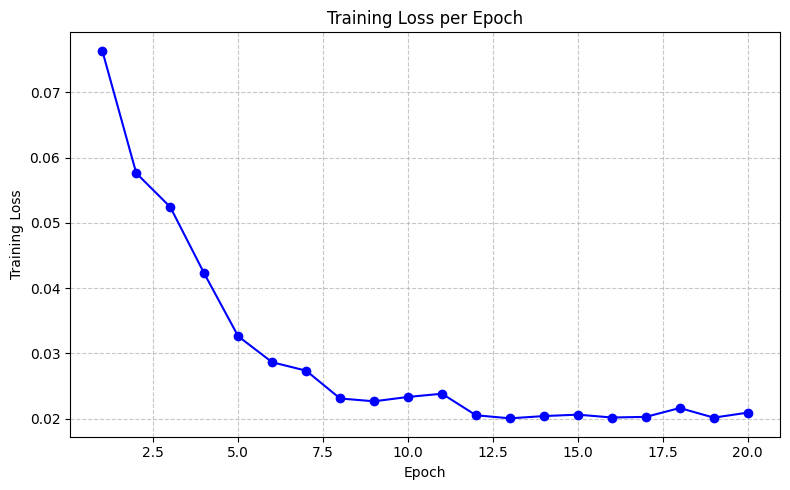

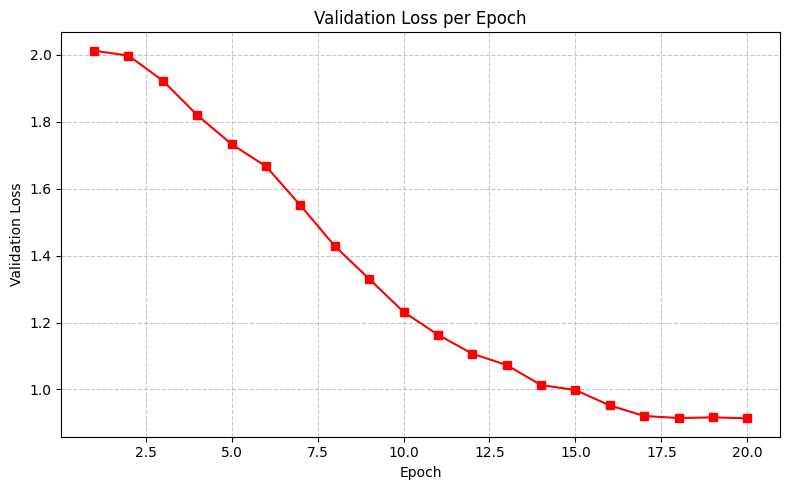

In [88]:
import matplotlib.pyplot as plt

# Plot Training Loss
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_loss_hist)+1), train_loss_hist, marker="o", color="blue")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("./figures/spain_local_transformer_train_loss.png", dpi=300)
plt.show()

# Plot Validation Loss
plt.figure(figsize=(8,5))
plt.plot(range(1, len(val_loss_ema)+1), val_loss_ema, marker="s", color="red")
plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("./figures/spain_local_transformer_val_loss.png", dpi=300)
plt.show()

In [22]:
from tqdm import tqdm
from torch_geometric.utils import subgraph

test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="🔍 Testing", leave=False)

    for batch_X, batch_Y in progress_bar:
        batch_X = batch_X.to(device)  # [B, T, N, 1]
        batch_Y = batch_Y.to(device)  # [B, N, 1]
        batch_Y = batch_Y.squeeze(1)

        batch_pred = []
        batch_actual = []
        node_losses = 0.0
        num_node_batches = 0

        for node_start in range(0, num_nodes, batch_size_nodes):
            node_end = min(node_start + batch_size_nodes, num_nodes)
            node_indices = torch.arange(node_start, node_end, device=device)

            # Slice node-wise input/output
            batch_X_nodes = batch_X[:, :, node_start:node_end, :]
            batch_Y_nodes = batch_Y[:, node_start:node_end, :]

            # Slice graph edges
            edge_index_sub, edge_weight_sub = subgraph(
                node_indices, edge_index, edge_weight,
                relabel_nodes=True, num_nodes=num_nodes
            )

            # Forward pass
            output = model(batch_X_nodes, edge_index_sub, edge_weight_sub, node_indices=node_indices)

            loss = criterion(output, batch_Y_nodes)
            node_losses += loss.item()
            num_node_batches += 1

            # Store for later
            batch_pred.append(output.cpu())
            batch_actual.append(batch_Y_nodes.cpu())

        # Aggregate loss and predictions
        avg_node_loss = node_losses / num_node_batches
        test_loss += avg_node_loss

        predictions.append(torch.cat(batch_pred, dim=1))  # [B, N_chunk, 1] → [B, N, 1]
        actuals.append(torch.cat(batch_actual, dim=1))    # [B, N_chunk, 1] → [B, N, 1]

        progress_bar.set_postfix({"Loss": f"{avg_node_loss:.4f}"})

# Final aggregation
predictions = torch.cat(predictions, dim=0)  # [total_samples, N, 1]
actuals = torch.cat(actuals, dim=0)          # [total_samples, N, 1]

print(f"\n✅ Final Test Loss: {test_loss / len(test_loader):.4f}")



✅ Final Test Loss: 0.6758


In [23]:
# Flatten and convert to numpy
pred_array = predictions.squeeze(-1).numpy()   # [num_samples]
actual_array = actuals.squeeze(-1).numpy()     # [num_samples]

print("Pred shape:", pred_array.shape)
print("Actual shape:", actual_array.shape)


Pred shape: (155, 52)
Actual shape: (155, 52)


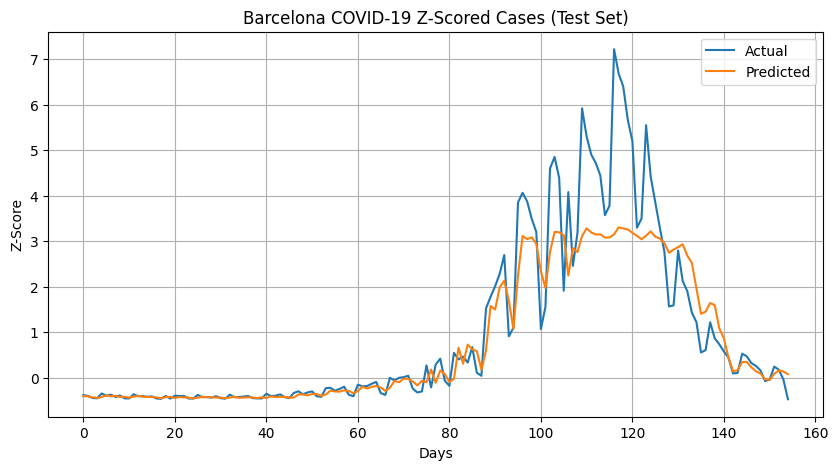

📉 RMSE for Barcelona: 0.8313


In [24]:
import matplotlib.pyplot as plt

city_name_list = list(centrality_df['nomemun'])
barcelona_index = city_name_list.index("Barcelona")

barcelona_preds = pred_array[:, barcelona_index]
barcelona_actuals = actual_array[:, barcelona_index]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(barcelona_actuals, label='Actual')
plt.plot(barcelona_preds, label='Predicted')
plt.title("Barcelona COVID-19 Z-Scored Cases (Test Set)")
plt.xlabel("Days")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.show()

# RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

# RMSE = sqrt(MSE)
rmse_barcelona = np.sqrt(mean_squared_error(barcelona_actuals, barcelona_preds))
print(f"📉 RMSE for Barcelona: {rmse_barcelona:.4f}")

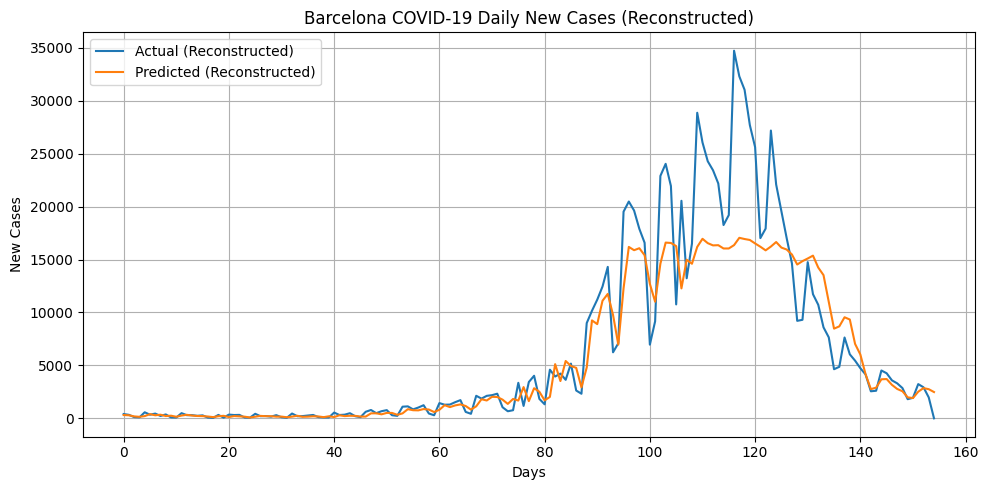

📉 RMSE for Barcelona: 3751.0163
📉 SMAPE for Barcelona: 19.75%
📈 MDA for Barcelona: 64.94%


In [25]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_squared_error
import numpy as np

# Build city graph from centrality dataframe
G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_name = row['nomemun']
    G2.add_node(city_name)

# Make sure predictions and actuals are [T, N]
pred_array = predictions.squeeze(-1).numpy()        # [T, N]
actual_array = actuals.squeeze(1).squeeze(-1).numpy()  # [T, N]

# Barcelona node name
city_name = "Barcelona"
city_id_list = list(G2.nodes())
barcelona_index = city_id_list.index(city_name)

# Get z-scored predictions and actuals
barcelona_preds_z = pred_array[:, barcelona_index]
barcelona_actuals_z = actual_array[:, barcelona_index]

# 🧠 Reconstruct actual daily cases
sp_original = df_covid[df_covid['provincia'] == city_name].copy()
sp_original['Casos'] = sp_original['Casos'].clip(lower=0)
sp_original = sp_original.sort_values('Fecha')

mean_barcelona = sp_original['Casos'].mean()
std_barcelona = sp_original['Casos'].std(ddof=0)

# 🔁 De-normalize predictions
barcelona_preds = barcelona_preds_z * std_barcelona + mean_barcelona
barcelona_actuals = barcelona_actuals_z * std_barcelona + mean_barcelona

# 📈 Plot
plt.figure(figsize=(10, 5))
plt.plot(barcelona_actuals, label='Actual (Reconstructed)')
plt.plot(barcelona_preds, label='Predicted (Reconstructed)')
plt.title("Barcelona COVID-19 Daily New Cases (Reconstructed)")
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("./figures/transformer_barcelona_no_gcn.png", dpi=300)
plt.show()

# RMSE = sqrt(MSE)
rmse_barcelona = np.sqrt(mean_squared_error(barcelona_actuals, barcelona_preds))
print(f"📉 RMSE for Barcelona: {rmse_barcelona:.4f}")

# SMAPE = Symmetric Mean Absolute Percentage Error
def smape(y_true, y_pred):
    return 100 * np.mean(
        np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)
    )

def mean_directional_accuracy(actual, predicted):
    # Ensure arrays are 1D
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    # Compute directional changes
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)

    # Compare signs of differences
    correct_directions = (actual_diff * pred_diff) > 0

    # Compute MDA
    return 100 * np.mean(correct_directions)

smape_barcelona = smape(barcelona_actuals, barcelona_preds)
print(f"📉 SMAPE for Barcelona: {smape_barcelona:.2f}%")

mda_barcelona = mean_directional_accuracy(barcelona_actuals, barcelona_preds)
print(f"📈 MDA for Barcelona: {mda_barcelona:.2f}%")

In [26]:
# Filter São Paulo full series
sp_full = filtered_covid_df[filtered_covid_df['provincia'] == city_name].sort_values('Fecha')

# Extract full z-scored series
full_z_series = sp_full['z_newCases'].tolist()
full_dates = sp_full['Fecha'].tolist()

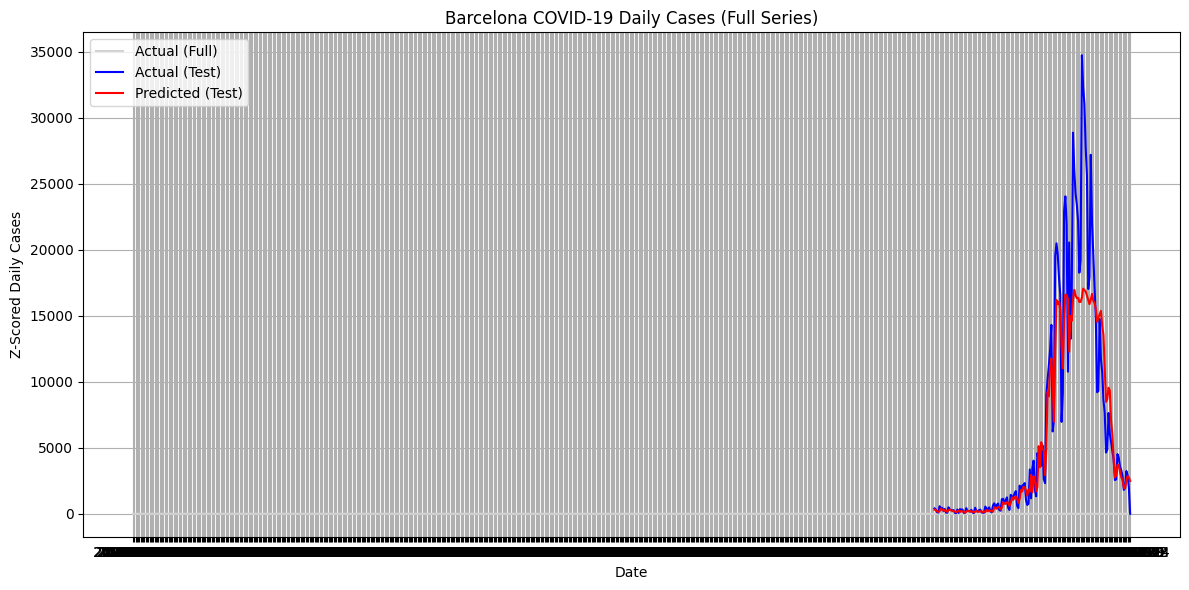

📉 RMSE for Barcelona: 3751.0163


In [27]:
# Find index where test set starts (80% of the full time series segments)
start_index = len(full_z_series) - len(barcelona_actuals)

plt.figure(figsize=(12, 6))
plt.plot(full_dates, full_z_series, label='Actual (Full)', color='lightgray')
plt.plot(full_dates[start_index:], barcelona_actuals, label='Actual (Test)', color='blue')
plt.plot(full_dates[start_index:], barcelona_preds, label='Predicted (Test)', color='red')
plt.title("Barcelona COVID-19 Daily Cases (Full Series)")
plt.xlabel("Date")
plt.ylabel("Z-Scored Daily Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_squared_error
import numpy as np

rmse_sp = np.sqrt(mean_squared_error(barcelona_actuals, barcelona_preds))
print(f"📉 RMSE for Barcelona: {rmse_sp:.4f}")

In [28]:
from sklearn.metrics import mean_squared_error
import numpy as np

# pred_array and actual_array are shaped [T, N] — where T is time and N is number of cities
num_cities = pred_array.shape[1]

# Calculate RMSE for each city
rmses = []
for i in range(num_cities):
    rmse = np.sqrt(mean_squared_error(actual_array[:, i], pred_array[:, i]))
    rmses.append(rmse)

# Compute average RMSE
avg_rmse = np.mean(rmses)
print(f"📊 Average RMSE across all cities: {avg_rmse:.4f}")

# Calculate SMAPE for each city
smapes = []
for i in range(num_cities):
    smape_i = smape(actual_array[:, i], pred_array[:, i])
    smapes.append(smape_i)

# Compute average SMAPE
avg_smape = np.mean(smapes)
print(f"📊 Average SMAPE across all cities: {avg_smape:.2f}%")

mdas = []
for i in range(num_cities):
    mda_i = mean_directional_accuracy(actual_array[:, i], pred_array[:, i])
    mdas.append(mda_i)

# Compute average MDA
avg_mda = np.mean(mdas)
print(f"📈 Average MDA across all cities: {avg_mda:.2f}%")


📊 Average RMSE across all cities: 0.8233
📊 Average SMAPE across all cities: 18.76%
📈 Average MDA across all cities: 55.84%


In [29]:
import numpy as np

# RMSE across all cities
rmse_mean = np.mean(rmses)
rmse_std  = np.std(rmses)
print(f"RMSE: {rmse_mean:.4f} ± {rmse_std:.4f}")

# SMAPE across all cities
smape_mean = np.mean(smapes)
smape_std  = np.std(smapes)
print(f"SMAPE: {smape_mean:.2f}% ± {smape_std:.2f}%")

# MDA across all cities
mda_mean = np.mean(mdas)
mda_std  = np.std(mdas)
print(f"MDA: {mda_mean:.2f}% ± {mda_std:.2f}%")

RMSE: 0.8233 ± 0.1089
SMAPE: 18.76% ± 3.11%
MDA: 55.84% ± 7.84%


In [119]:
pop_df = pd.read_csv("data/Spain/final_cleaned_population_by_province_2025.csv")
scaler = MinMaxScaler()
top_240_pop_cities = set(pop_df.sort_values(by="Population_2025", ascending=False)["Province"].head(40).tolist())
pop_df["Population_2025_Normalized"] = scaler.fit_transform(pop_df[["Population_2025"]])

In [46]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Map: city code → population
pop_dict = dict(zip(pop_df["Province"], pop_df["Population_2025"]))

rmse_per_100k_list = []

for i, city_code in enumerate(cities):
    if city_code not in pop_dict:
        continue  # skip if population not found

    pred_z = pred_array[:, i]
    actual_z = actual_array[:, i]

    # Restore real values
    city_df = spain_covid_df[spain_covid_df['provincia'] == city_code].copy()
    city_df['Casos'] = city_df['Casos'].clip(lower=0).sort_values()

    mean_city = city_df['Casos'].mean()
    std_city = city_df['Casos'].std(ddof=0)

    if np.isnan(std_city) or std_city == 0 or np.isnan(mean_city):
        continue  # skip cities with undefined or constant data

    pred_real = pred_z * std_city + mean_city
    actual_real = actual_z * std_city + mean_city

    population = pop_dict[city_code]

    pred_per_100k = pred_real / population * 100000
    actual_per_100k = actual_real / population * 100000

    # Check for NaNs in reconstructed arrays
    mask = ~np.isnan(actual_per_100k) & ~np.isnan(pred_per_100k)

    if mask.sum() == 0:
        continue  # skip if nothing left after masking

    rmse = np.sqrt(mean_squared_error(actual_per_100k[mask], pred_per_100k[mask]))
    rmse_per_100k_list.append(rmse)

# Final result
avg_rmse_per_100k = np.mean(rmse_per_100k_list)
std_rmse_per_100k  = np.std(mdas)
print(f"📉 Average RMSE per 100k population:: {avg_rmse_per_100k:.2f}% ± {std_rmse_per_100k:.2f}%")


📉 Average RMSE per 100k population:: 49.90% ± 7.84%


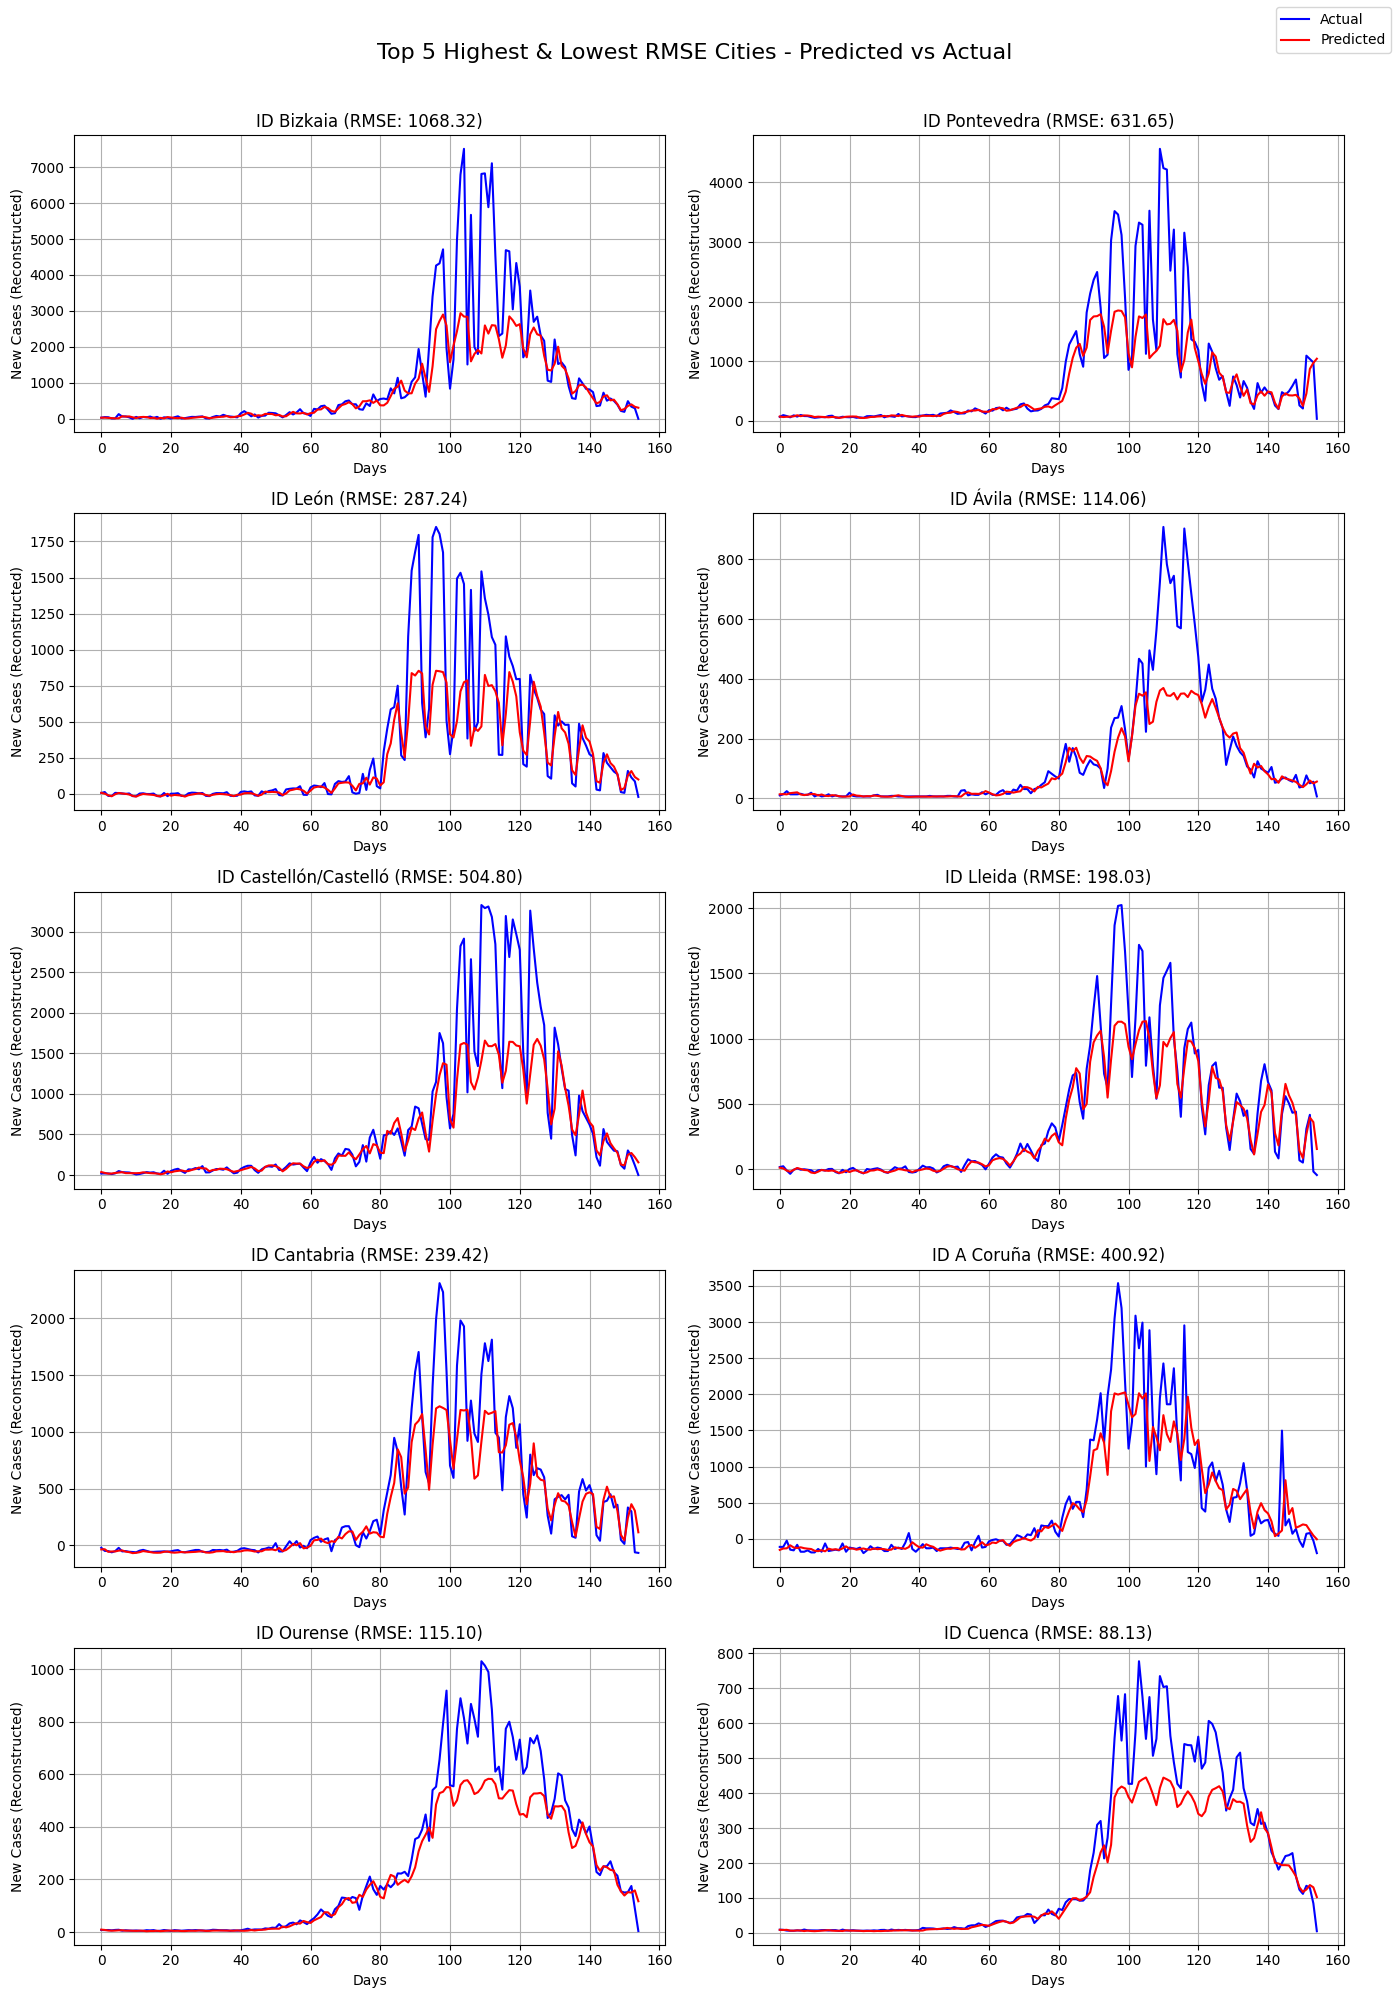

In [121]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Compute RMSE per city
city_rmses = []
for i, city_id in enumerate(city_id_list):
    actual = actual_array[:, i]
    pred = pred_array[:, i]
    rmse = np.sqrt(mean_squared_error(actual, pred))
    city_rmses.append((city_id, rmse))

# Step 2: Sort and get top 5 and bottom 5
top_5 = sorted(city_rmses, key=lambda x: x[1], reverse=True)[:5]
bottom_5 = sorted(city_rmses, key=lambda x: x[1])[:5]

# Step 3: Create mapping from city ID to name
id_to_name = dict(zip(centrality_df['Codmundv'], centrality_df['nomemun']))

# Step 4: Plotting helper
def plot_city_prediction(city_id, ax):
    city_name = id_to_name.get(city_id, f"ID {city_id}")
    city_index = city_id_list.index(city_id)

    # Get Z-scored predictions and actuals
    pred_z = pred_array[:, city_index]
    actual_z = actual_array[:, city_index]

    # Compute mean & std from original covid_df
    city_data = df_covid[df_covid['provincia'] == city_id].copy()
    city_data['Casos'] = city_data['Casos'].clip(lower=0)
    mean = city_data['Casos'].mean()
    std = city_data['Casos'].std(ddof=0)

    # Invert Z-score to get original scale
    pred = pred_z * std + mean
    actual = actual_z * std + mean

    # Plot
    ax.plot(actual, label='Actual', color='blue')
    ax.plot(pred, label='Predicted', color='red')
    rmse = np.sqrt(mean_squared_error(actual, pred))
    ax.set_title(f"{city_name} (RMSE: {rmse:.2f})")
    ax.set_xlabel("Days")
    ax.set_ylabel("New Cases (Reconstructed)")
    ax.grid(True)


# Step 5: Plot all 10 cities
fig, axs = plt.subplots(5, 2, figsize=(14, 20))
fig.suptitle("Top 5 Highest & Lowest RMSE Cities - Predicted vs Actual", fontsize=16)

for i, (city_id, _) in enumerate(top_5 + bottom_5):
    ax = axs[i // 2, i % 2]
    plot_city_prediction(city_id, ax)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0, 0.98, 0.97])
plt.show()


In [314]:
import os
import torch

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/Spain-Experiment-Local-Transformer-Without-GCN-1-120-Epoch-Checkpoint.pth")